# Computer Vision

## Task 1

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [1]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [5]:
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64  # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
           'frog', 'horse', 'ship', 'truck')  # Классы CIFAR10

In [6]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(
        root='/content', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_set = torchvision.datasets.CIFAR10(
        root='/content', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader


train_loader, test_loader = load_dataloaders()

print('количество батчей в train_loader: ', len(train_loader))
print('количество батчей в test_loader: ', len(test_loader))

100%|██████████| 170498071/170498071 [00:13<00:00, 12881418.64it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
количество батчей в train_loader:  782
количество батчей в test_loader:  157


## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](/misc/images/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [7]:
import matplotlib.pyplot as plt


def imshow(img, labels, padding_size=15, labels_split_size=25):
    img = torchvision.utils.make_grid(images)
    # убрать нормализацию
    img = img / 2 + 0.5
    npimg = img.numpy()
    label_text = (
        ' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
           cat           ship           ship           plane


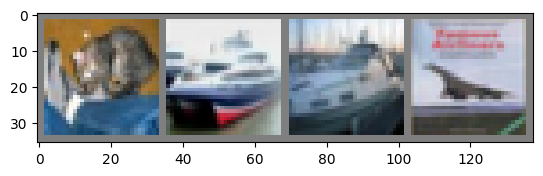

In [8]:
trainloader, testloader = load_dataloaders(batch_size=4)
images, labels = next(iter(testloader))
imshow(images, labels, padding_size=11, labels_split_size=11)

## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../misc/images/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться:
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv_3 = nn.Conv2d(3, 32, 1)

        self.residual_block = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32)
        )

        self.clf = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        out = self.residual_block(x)
        out += self.conv_3(x)
        out = self.clf(out)

        return out


residualnet = ResidualNet()

In [10]:
net = ResidualNet()
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [11]:
class Trainer:

    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)

        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):

        self.train_loss_log = []
        self.train_acc_log = []
        self.test_loss_log = []
        self.test_acc_log = []

        for epoch in range(n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(
                f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")

    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

In [12]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1),
                trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1),
                trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1),
                trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1),
                trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

In [21]:
opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
crit = nn.CrossEntropyLoss()
trn = Trainer(net, opt, crit)
trn.train(train_loader, test_loader, n_epochs=20)

Сеть загружена на cuda:0
Epoch 0
 train loss: 46.96136816566253, train acc: 0.746962915601023
 test loss: 49.45631182725263, test acc: 0.7336783439490446

Epoch 1
 train loss: 45.12936700030666, train acc: 0.7567734974424553
 test loss: 49.836361295858005, test acc: 0.7338773885350318

Epoch 2
 train loss: 44.2902140971035, train acc: 0.7625679347826086
 test loss: 48.59329359698447, test acc: 0.7399482484076433

Epoch 3
 train loss: 43.61595130881385, train acc: 0.7646059782608695
 test loss: 48.198787634539755, test acc: 0.7397492038216561

Epoch 4
 train loss: 43.13724387576208, train acc: 0.7649656329923273
 test loss: 47.52946127144394, test acc: 0.7506966560509554

Epoch 5
 train loss: 42.51519660937512, train acc: 0.7702006074168798
 test loss: 49.534875207645875, test acc: 0.7353702229299363

Epoch 6
 train loss: 42.11391425071775, train acc: 0.7726182864450127
 test loss: 47.27500696850431, test acc: 0.7492038216560509

Epoch 7
 train loss: 41.647395187631595, train acc: 0.774

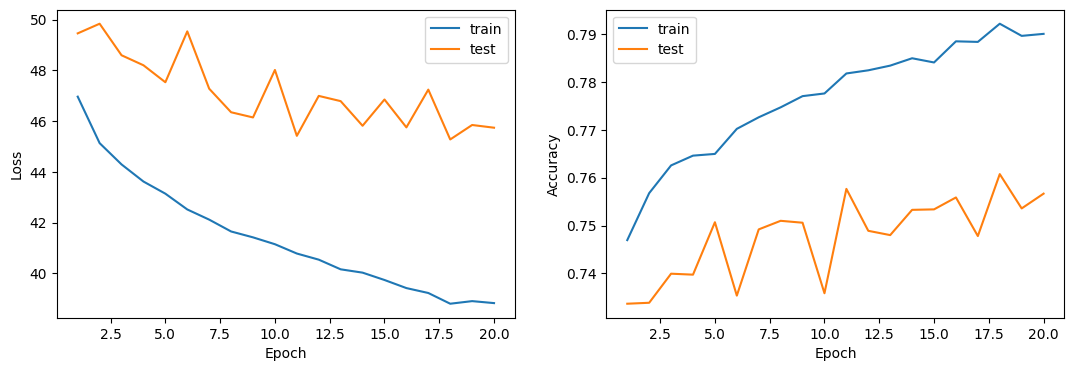

In [22]:
plot_train_log(trn)

## Task 5

Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет.
![sample](../misc/images/images_sample.png)
![sample](../misc/images/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

Files already downloaded and verified
Files already downloaded and verified
           cat           ship           ship           plane


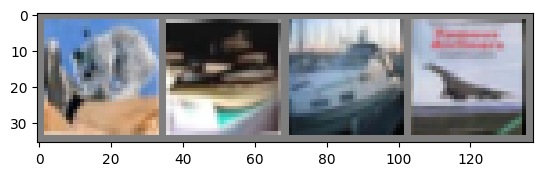

In [15]:
transform_v2 = transforms.Compose(
    [
        transforms.ElasticTransform(alpha=10.0),
        transforms.RandomInvert(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
trainloader, testloader = load_dataloaders(transform=transform_v2, batch_size=4)
images, labels = next(iter(testloader))
imshow(images, labels, padding_size=11, labels_split_size=11)

In [16]:
train_loader_v2, test_loader_v2 = load_dataloaders(transform=transform_v2)
trn.train(train_loader_v2, test_loader_v2, n_epochs=15)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 76.31796473188473, train acc: 0.5897937979539642
 test loss: 76.19562614343728, test acc: 0.5949442675159236

Epoch 1
 train loss: 69.81025242866457, train acc: 0.6235813618925832
 test loss: 73.40708916050613, test acc: 0.6080812101910829

Epoch 2
 train loss: 67.07952592805829, train acc: 0.6408847506393862
 test loss: 66.37325834772389, test acc: 0.6378383757961783

Epoch 3
 train loss: 65.38076685883505, train acc: 0.6508152173913043
 test loss: 70.30984578466719, test acc: 0.6230095541401274

Epoch 4
 train loss: 64.02606838255588, train acc: 0.6557504795396419
 test loss: 69.91361380534566, test acc: 0.6237062101910829

Epoch 5
 train loss: 62.779094514334595, train acc: 0.6639026534526854
 test loss: 62.50384594376679, test acc: 0.6651074840764332

Epoch 6
 train loss: 61.75829849584633, train acc: 0.6707161125319693
 test loss: 60.81733419333294, test acc: 0.6762539808917197

Epoch 

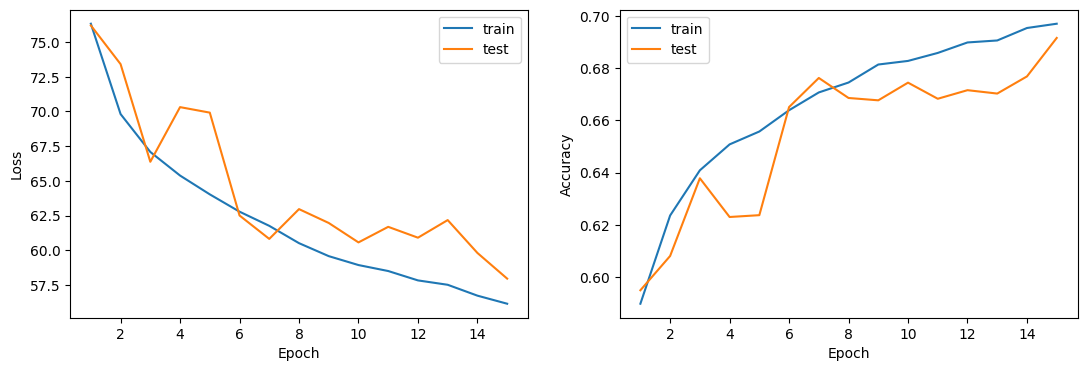

In [17]:
plot_train_log(trn)

Files already downloaded and verified
Files already downloaded and verified
           cat           ship           ship           plane


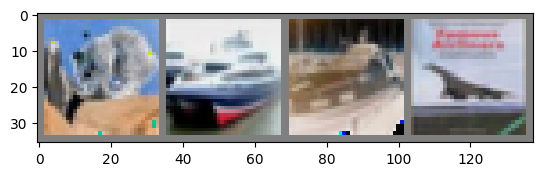

In [18]:
transform_v3 = transforms.Compose(
    [
        transforms.RandomSolarize(threshold=19.0),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
trainloader, testloader = load_dataloaders(transform=transform_v3, batch_size=4)
images, labels = next(iter(testloader))
imshow(images, labels, padding_size=11, labels_split_size=11)

In [19]:
train_loader_v3, test_loader_v3 = load_dataloaders(transform=transform_v3)
trn.train(train_loader_v3, test_loader_v3, n_epochs=15)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 60.541366447878005, train acc: 0.6792479219948849
 test loss: 61.44446189540207, test acc: 0.6679936305732485

Epoch 1
 train loss: 58.64724526563874, train acc: 0.686880594629156
 test loss: 62.05049808769469, test acc: 0.6666998407643312

Epoch 2
 train loss: 57.74156843609822, train acc: 0.6913363171355499
 test loss: 60.543784159763604, test acc: 0.6730692675159236

Epoch 3
 train loss: 57.078977148246274, train acc: 0.6965712915601023
 test loss: 61.470880447679264, test acc: 0.6697850318471338

Epoch 4
 train loss: 56.70333219794056, train acc: 0.6971307544757033
 test loss: 59.4401036766684, test acc: 0.6812300955414012

Epoch 5
 train loss: 56.07567332223858, train acc: 0.6987891624040921
 test loss: 61.0031092698407, test acc: 0.673765923566879

Epoch 6
 train loss: 55.59250842091982, train acc: 0.7029451726342711
 test loss: 58.39781615384825, test acc: 0.685609076433121

Epoch 7


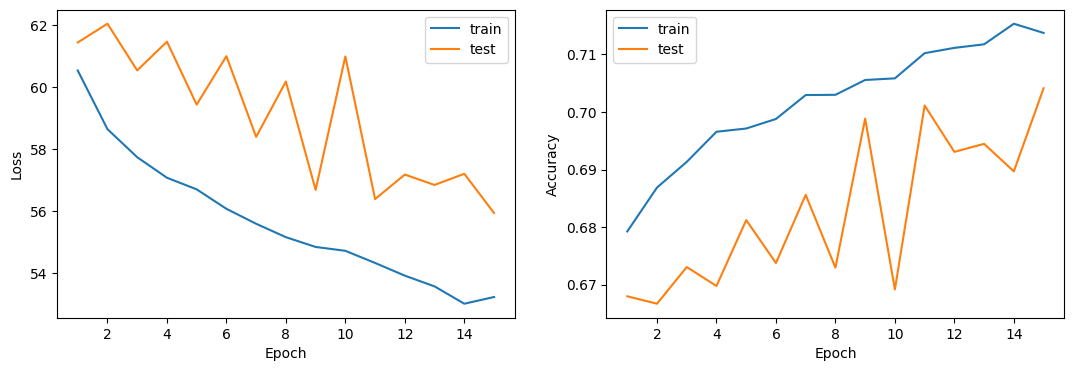

In [20]:
plot_train_log(trn)